### Multi-level Models

In [1]:
# import general purpsoe libraries
import os
import sys

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# objtain data from LEASPY
from leaspy.datasets import Loader
df = Loader.load_dataset("parkinson-putamen-train_and_test")
df.head()

PUTAMEN
ID     TIME      SPLIT          
GS-001 71.354607 train  0.728492
       71.554604 train  0.735620
       72.054604 train  0.757409
       73.054604 train  0.800754
       73.554604 train  0.870756

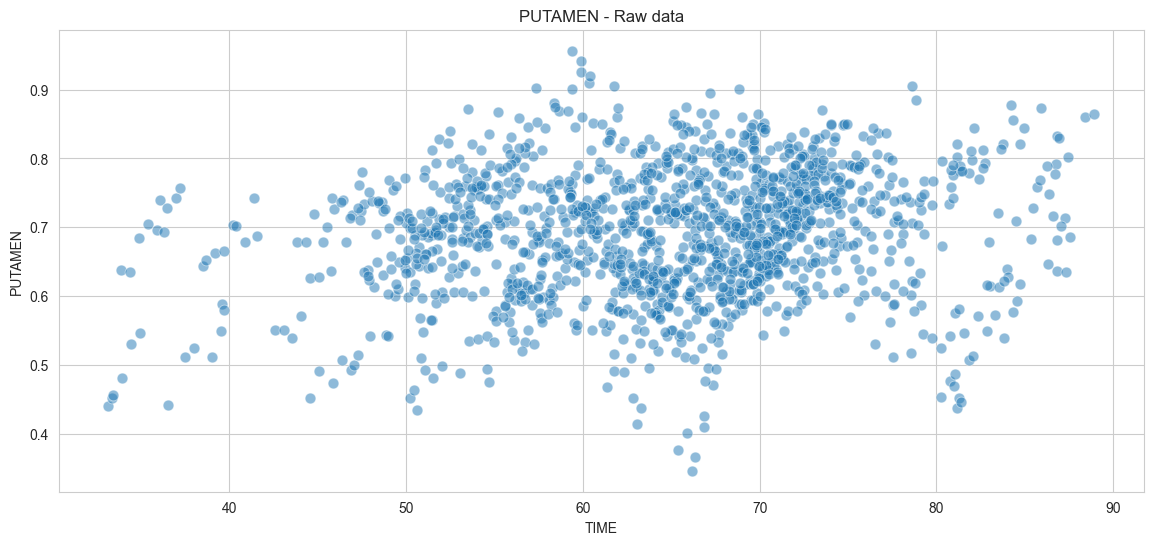

In [3]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))
sns.scatterplot(
    data=df.reset_index().query("SPLIT == 'train'"),
    x="TIME",
    y="PUTAMEN",
    alpha=0.5,
    s=60,
)
plt.title("PUTAMEN - Raw data")
plt.show()

In [4]:
def get_title(overall_results, model_name):
    """Precise model's name and its RMSE train & test"""
    rmse_train = overall_results.loc[model_name, "train"]
    rmse_test = overall_results.loc[model_name, "test"]
    title = f"PUTAMEN - Raw data vs {model_name:s}\n"
    title += r"$RMSE_{train}$ = %.3f     $RMSE_{test}$ = %.3f" % (rmse_train, rmse_test)
    return title


def plot_individuals(df, overall_results, model_name, **kwargs):
    # ---- Input manager
    kind = kwargs.get("kind", "lines")
    sublist = kwargs.get("sublist", None)
    highlight_test = kwargs.get("highlight_test", True)
    ax = kwargs.get("ax", None)

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 6))
    else:
        plt.figure(figsize=(14, 6))

    # ---- Select subjects
    if sublist is None:
        sublist = df.index.unique("ID")

    # ---- If too many subject, do not display them in the legend
    display_id_legend = len(sublist) <= 10

    # ---- Plot
    if kind == "scatter":
        # -- Used for Linear Regression
        sns.scatterplot(
            data=df.reset_index(),
            x="TIME",
            y="PUTAMEN",
            alpha=0.5,
            s=60,
            label="Observations",
            ax=ax,
        )
        ax.plot(
            df.index.get_level_values("TIME").values,
            df[model_name].values,
            label=model_name,
            c="C1",
        )
        ax.legend(title="LABEL")
        if highlight_test:
            test = df.xs("test", level="SPLIT").loc[sublist].reset_index()
            sns.scatterplot(data=test, x="TIME", y="PUTAMEN", legend=None, ax=ax)

    elif kind == "lines":
        # -- Used for the other models
        # - Stack observations & reconstructions by the model
        df_stacked = df[["PUTAMEN", model_name]].copy()
        df_stacked.rename(columns={"PUTAMEN": "Observations"}, inplace=True)
        df_stacked = df_stacked.stack().reset_index().set_index(["ID", "SPLIT"])
        df_stacked.columns = ["TIME", "LABEL", "PUTAMEN"]

        # - Plot
        sns.lineplot(
            data=df_stacked.loc[sublist],
            x="TIME",
            y="PUTAMEN",
            hue="ID",
            style="LABEL",
            legend=display_id_legend,
            ax=ax,
        )
        if highlight_test:
            test = df.xs("test", level="SPLIT").loc[sublist].reset_index()
            sns.scatterplot(
                data=test, x="TIME", y="PUTAMEN", hue="ID", legend=None, ax=ax
            )
        if display_id_legend:
            ax.legend(title="LABEL", bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        raise ValueError(
            '<kind> input accept only "scatter" and "lines".' f" You gave {kind}"
        )

    ax.set_title(get_title(overall_results, model_name))
    return ax

In [5]:
pds = pd.IndexSlice
df_train = df.loc[pds[:, :, "train"]].copy()  # one possibility
df_test = df.xs("test", level="SPLIT").copy()  # an other one

In [6]:
x = df_train.index.get_level_values("TIME").values
y = df_train["PUTAMEN"].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

In [7]:
df["Linear Regression"] = intercept + slope * df.index.get_level_values("TIME")

In [8]:
overall_results = pd.DataFrame({"train": [], "test": []})


def compute_rmse(df, model_name):
    """Compute RMSE between PUTAMEN column and the <model_name> column of df"""
    y = df["PUTAMEN"]
    y_hat = df[model_name]
    diff = y - y_hat
    return np.sqrt(np.mean(diff * diff))


def compute_rmse_train_test(df, overall_results, model_name):
    """Inplace modification of <overall_results>"""
    overall_results.loc[model_name, "train"] = compute_rmse(
        df.xs("train", level="SPLIT"), model_name
    )
    overall_results.loc[model_name, "test"] = compute_rmse(
        df.xs("test", level="SPLIT"), model_name
    )


compute_rmse_train_test(df, overall_results, "Linear Regression")
overall_results

,train,test
Linear Regression,0.091403,0.10213


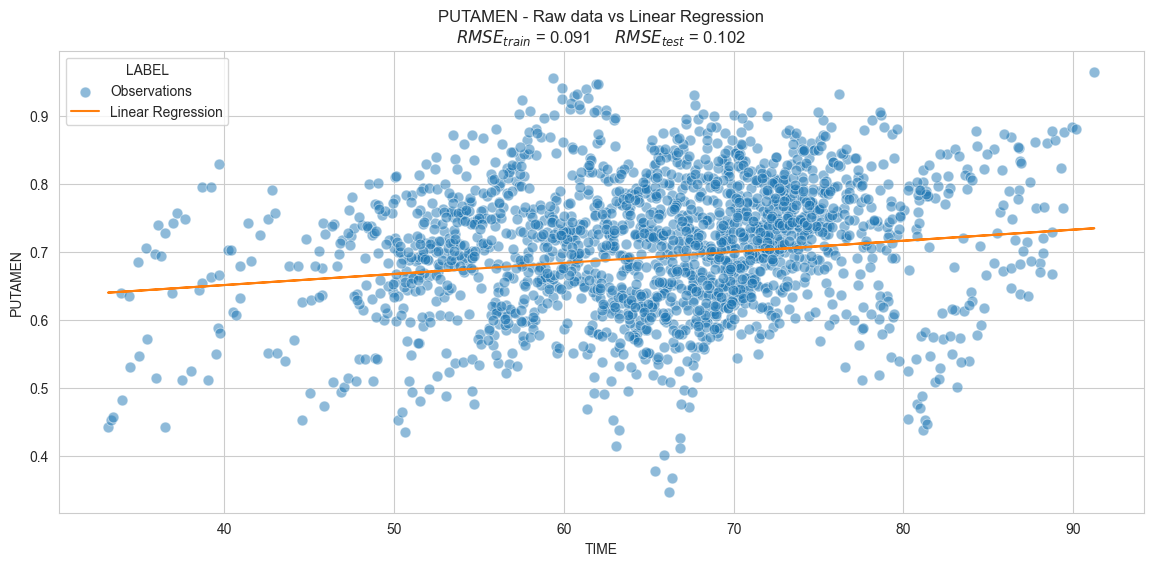

In [9]:
plot_individuals(
    df, overall_results, "Linear Regression", kind="scatter", highlight_test=False
)
plt.show()

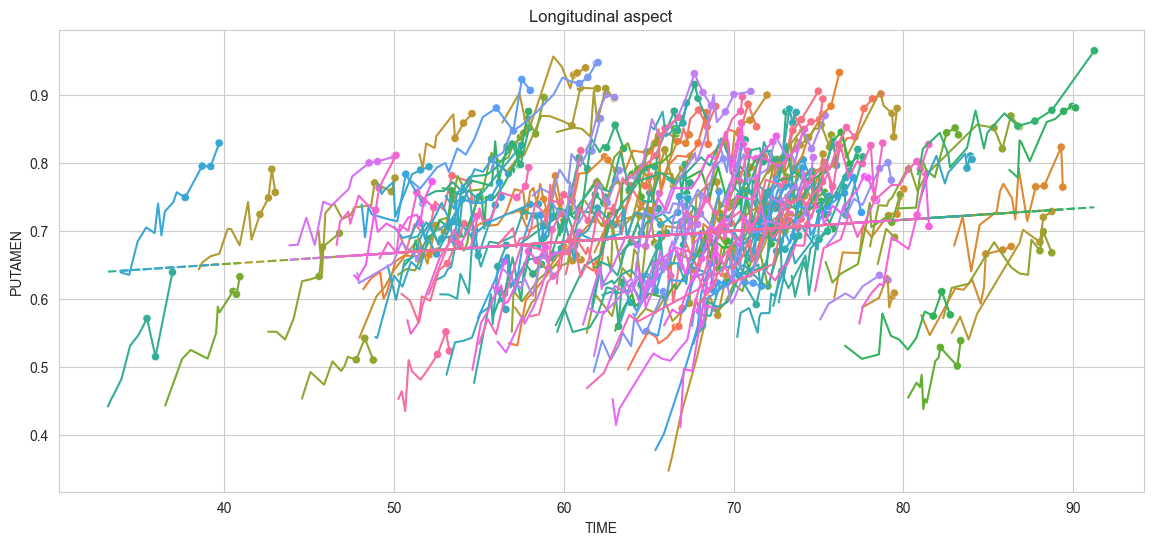

In [10]:
plot_individuals(
    df, overall_results, "Linear Regression", kind="lines", highlight_test=True
)
plt.title("Longitudinal aspect")
plt.show()

## Mixed Effects Model with Statsmodels

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLMParams

In [12]:
lmm = smf.mixedlm(
    formula="PUTAMEN ~ 1 + TIME",
    data=df_train.reset_index(),
    groups="ID",
    re_formula="~ 1 + TIME",
).fit()
lmm.summary()

g:\My Drive\01-ejw-data-github\Public\Library\stats\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
g:\My Drive\01-ejw-data-github\Public\Library\stats\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
g:\My Drive\01-ejw-data-github\Public\Library\stats\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:              MixedLM Dependent Variable: PUTAMEN  
No. Observations:   1415    Method:             REML     
No. Groups:         200     Scale:              0.0007   
Min. group size:    2       Log-Likelihood:     2497.0458
Max. group size:    13      Converged:          Yes      
Mean group size:    7.1                                  
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept     -0.685    0.044 -15.644 0.000 -0.771 -0.599
TIME           0.022    0.001  29.528 0.000  0.020  0.023
ID Var         0.003    0.259                            
ID x TIME Cov  0.000    0.005                            
TIME Var       0.000    0.000                            
=========================================================

"""

## Mixed Effect Models with Leaspy

In [13]:
# --- Import methods
from leaspy import Leaspy, Data, AlgorithmSettings

# --- Format the data
data = Data.from_dataframe(df_train[["PUTAMEN"]])

# --- Fit a model
leaspy_univariate = Leaspy("univariate_linear")
settings_fit = AlgorithmSettings("mcmc_saem", progress_bar=True, seed=0)
leaspy_univariate.fit(data, settings_fit)

 ==> Setting seed to 0
|##################################################|   10000/10000 iterations

Fit with `mcmc_saem` took: 31s
The standard deviation of the noise at the end of the fit is:
2.13%


In [14]:
settings_personalize = AlgorithmSettings(
    "scipy_minimize", progress_bar=True, use_jacobian=True
)

individual_parameters = leaspy_univariate.personalize(data, settings_personalize)

|##################################################|   200/200 subjects

Personalize with `scipy_minimize` took: 3s
The standard deviation of the noise at the end of the personalize is:
1.83%


In [15]:
timepoints = {
    idx: df.loc[idx].index.get_level_values("TIME").values
    for idx in df.index.get_level_values("ID").unique()
}
estimates = leaspy_univariate.estimate(timepoints, individual_parameters)

In [16]:
df["Leaspy linear"] = float("nan")

for idx in df.index.unique("ID"):
    df.loc[idx, "Leaspy linear"] = estimates[idx]

In [17]:
individual_parameters = pd.DataFrame({"INTERCEPT": [], "SLOPE": []})

subject_idx = "GS-194"


def compute_individual_parameters(df, subject_idx):
    df_patient = df.loc[subject_idx]

    x = df_patient.index.get_level_values("TIME").values
    y = df_patient["PUTAMEN"].values

    # -- Linear regression
    slope, intercept, _, _, _ = stats.linregress(x, y)

    return intercept, slope


individual_parameters.loc[subject_idx] = compute_individual_parameters(
    df_train, subject_idx
)

for subject_idx in df_train.index.unique("ID"):

    slope, intercept = compute_individual_parameters(df_train, subject_idx)
    individual_parameters.loc[subject_idx] = (intercept, slope)

individual_parameters.head()

,INTERCEPT,SLOPE
GS-194,0.025188,-0.807941
GS-001,0.051464,-2.946305
GS-002,0.018643,-0.252949
GS-003,0.003816,0.517972
GS-004,0.025680,-1.076280


In [18]:
def compute_individual_reconstruction(x, parameters):

    subject_idx = x.name[0]

    slope = parameters.loc[subject_idx]["SLOPE"]
    intercept = parameters.loc[subject_idx]["INTERCEPT"]

    time = x.name[1]

    return intercept + slope * time


df["Individual Linear Regression"] = df.apply(
    lambda x: compute_individual_reconstruction(x, individual_parameters), axis=1
)

In [19]:
df.head()

PUTAMEN  Linear Regression  Leaspy linear  \
ID     TIME      SPLIT                                               
GS-001 71.354607 train  0.728492           0.702037       0.731323   
       71.554604 train  0.735620           0.702363       0.740756   
       72.054604 train  0.757409           0.703178       0.764339   
       73.054604 train  0.800754           0.704808       0.811506   
       73.554604 train  0.870756           0.705623       0.835089   

                        Individual Linear Regression  
ID     TIME      SPLIT                                
GS-001 71.354607 train                   -210.180937  
       71.554604 train                   -210.770189  
       72.054604 train                   -212.243341  
       73.054604 train                   -215.189646  
       73.554604 train                   -216.662798

In [21]:
compute_rmse_train_test(df, overall_results, "Linear Mixed Effect Model")

overall_results

KeyError: 'Linear Mixed Effect Model'

KeyError: 'Individual Linear Regression'

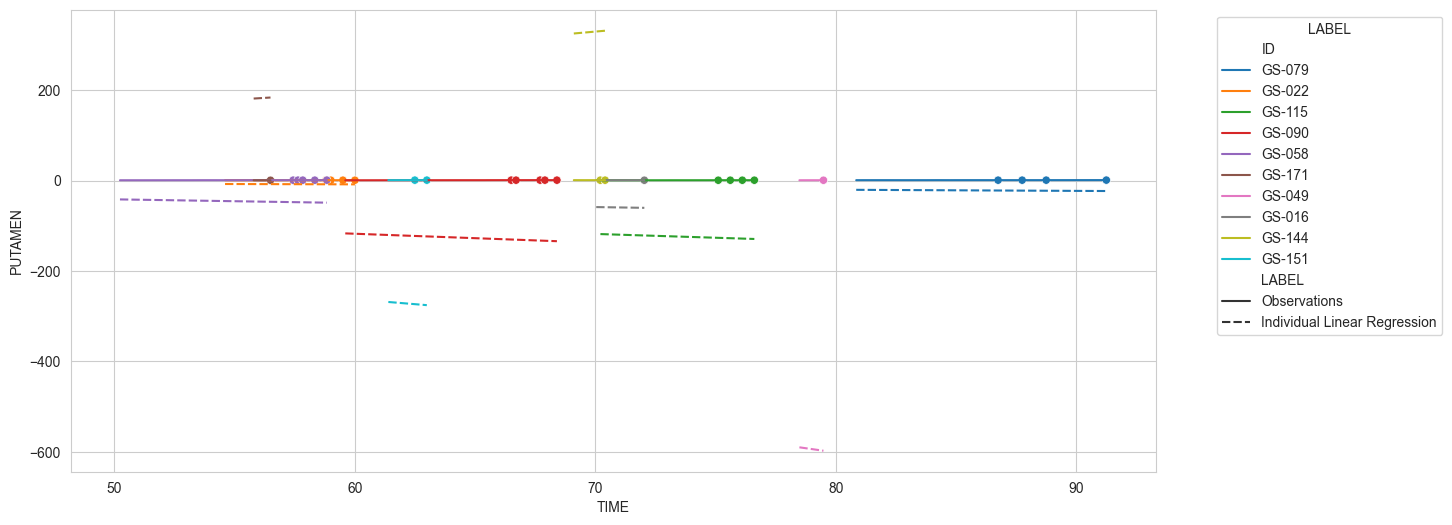

In [20]:
visits_per_subjects = (
    df.groupby(df.index.get_level_values("ID")).count().sort_values("PUTAMEN")
)
sublist = visits_per_subjects.tail(5).index.tolist()
sublist += visits_per_subjects.head(5).index.tolist()

plot_individuals(df, overall_results, "Individual Linear Regression", sublist=sublist)
plt.show()

In [20]:
plot_individuals(df, overall_results, "Leaspy linear", sublist=sublist)
plt.show()

NameError: name 'sublist' is not defined